In [11]:
# Import required libraries
import json
import numpy as np
import pandas as pd
from typing import List, Dict, Any, Set, Tuple
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re

def load_evaluation_data(gt_path: str, naive_path: str, enriched_path: str) -> tuple:
    """
    Load ground truth, naive answers, and enriched answers from JSON files
    """
    with open(gt_path, 'r') as f:
        ground_truth = json.load(f)
    with open(naive_path, 'r') as f:
        naive_answers = json.load(f)
    with open(enriched_path, 'r') as f:
        enriched_answers = json.load(f)
    return ground_truth, naive_answers, enriched_answers

class CustomRougeCalculator:
    @staticmethod
    def _preprocess_text(text: str) -> List[str]:
        """
        Preprocess text by converting to lowercase, removing punctuation and splitting into words
        """
        # Convert to lowercase and remove punctuation
        text = re.sub(r'[^\w\s]', '', text.lower())
        # Split into words
        return text.split()

    @staticmethod
    def _get_ngrams(words: List[str], n: int) -> Set[Tuple[str, ...]]:
        """
        Get n-grams from a list of words
        """
        return set(tuple(words[i:i+n]) for i in range(len(words)-n+1))

    @staticmethod
    def _count_ngrams(words: List[str], n: int) -> Counter:
        """
        Count n-grams in a list of words
        """
        ngrams = [tuple(words[i:i+n]) for i in range(len(words)-n+1)]
        return Counter(ngrams)

    @staticmethod
    def _lcs_length(words1: List[str], words2: List[str]) -> int:
        """
        Calculate length of Longest Common Subsequence between two word lists
        """
        m, n = len(words1), len(words2)
        dp = [[0] * (n + 1) for _ in range(m + 1)]
        
        for i in range(1, m + 1):
            for j in range(1, n + 1):
                if words1[i-1] == words2[j-1]:
                    dp[i][j] = dp[i-1][j-1] + 1
                else:
                    dp[i][j] = max(dp[i-1][j], dp[i][j-1])
        
        return dp[m][n]

    def calculate_scores(self, reference: str, candidate: str) -> Dict[str, float]:
        """
        Calculate ROUGE-1, ROUGE-2, and ROUGE-L scores
        """
        # Preprocess texts
        ref_words = self._preprocess_text(reference)
        cand_words = self._preprocess_text(candidate)

        scores = {}

        # Calculate ROUGE-1
        ref_unigrams = self._count_ngrams(ref_words, 1)
        cand_unigrams = self._count_ngrams(cand_words, 1)
        
        matching_unigrams = sum((ref_unigrams & cand_unigrams).values())
        if len(ref_words) == 0 or len(cand_words) == 0:
            scores['rouge1'] = 0.0
        else:
            recall = matching_unigrams / len(ref_words)
            precision = matching_unigrams / len(cand_words)
            scores['rouge1'] = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        # Calculate ROUGE-2
        if len(ref_words) < 2 or len(cand_words) < 2:
            scores['rouge2'] = 0.0
        else:
            ref_bigrams = self._count_ngrams(ref_words, 2)
            cand_bigrams = self._count_ngrams(cand_words, 2)
            matching_bigrams = sum((ref_bigrams & cand_bigrams).values())
            
            recall = matching_bigrams / max(1, len(ref_words) - 1)
            precision = matching_bigrams / max(1, len(cand_words) - 1)
            scores['rouge2'] = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        # Calculate ROUGE-L
        lcs_len = self._lcs_length(ref_words, cand_words)
        if len(ref_words) == 0 or len(cand_words) == 0:
            scores['rougeL'] = 0.0
        else:
            recall = lcs_len / len(ref_words)
            precision = lcs_len / len(cand_words)
            scores['rougeL'] = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        return scores

class RAGEvaluator:
    def __init__(self, ground_truth: List[Dict], naive_answers: List[Dict], enriched_answers: List[Dict]):
        """
        Initialize the RAG evaluator with the evaluation data
        """
        self.ground_truth = {item['question']: item['answer'] for item in ground_truth}
        self.naive_answers = {item['question']: item['answer'] for item in naive_answers}
        self.enriched_answers = {item['question']: item['answer'] for item in enriched_answers}
        self.rouge_calculator = CustomRougeCalculator()
        
    def calculate_rouge_scores(self, system_answers: Dict[str, str]) -> Dict[str, float]:
        """
        Calculate ROUGE scores for a set of system answers
        """
        scores = defaultdict(list)
        
        for question, gt_answer in self.ground_truth.items():
            if question in system_answers:
                score = self.rouge_calculator.calculate_scores(gt_answer, system_answers[question])
                for metric, value in score.items():
                    scores[metric].append(value)
                    
        return {metric: np.mean(values) for metric, values in scores.items()}
    
    def evaluate_all(self) -> Dict[str, Dict[str, float]]:
        """
        Evaluate both naive and enriched systems
        """
        results = {
            'naive': self.calculate_rouge_scores(self.naive_answers),
            'enriched': self.calculate_rouge_scores(self.enriched_answers)
        }
        return results
    
    def plot_results(self, results: Dict[str, Dict[str, float]]):
        """
        Plot evaluation results
        """
        data = []
        for system, scores in results.items():
            for metric, score in scores.items():
                data.append({
                    'System': system.capitalize(),
                    'Metric': metric.upper(),
                    'Score': score
                })
        
        df = pd.DataFrame(data)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=df, x='Metric', y='Score', hue='System')
        plt.title('RAG System Evaluation Results')
        plt.ylabel('Score')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()



In [16]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\prana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\prana\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:
# Example usage in notebook:

# Cell 1: Load data
ground_truth, naive_answers, enriched_answers = load_evaluation_data(
    "results json/ground_truth.json",
    "results json/naive_answers.json",
    "results json/metadata_answers.json"
)


In [14]:

# Cell 2: Initialize evaluator and run evaluation
evaluator = RAGEvaluator(ground_truth, naive_answers, enriched_answers)
results = evaluator.evaluate_all()



Evaluation Results:

Naive System:
--------------------
rouge1: 0.0289
rouge2: 0.0116
rougeL: 0.0192

Enriched System:
--------------------
rouge1: 0.0264
rouge2: 0.0102
rougeL: 0.0197


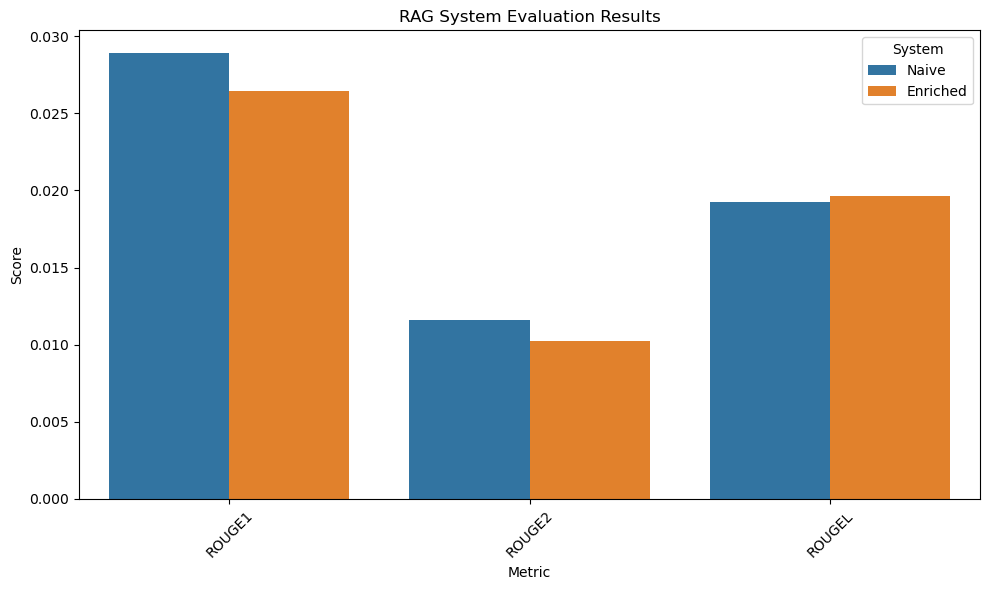

In [15]:
# Cell 3: Print results
print("\nEvaluation Results:")
print("==================")
for system, metrics in results.items():
    print(f"\n{system.capitalize()} System:")
    print("-" * 20)
    for metric, score in metrics.items():
        print(f"{metric}: {score:.4f}")

# Cell 4: Plot results
evaluator.plot_results(results)


In [17]:
# Import required libraries
import json
import numpy as np
import pandas as pd
from typing import List, Dict, Any, Set, Tuple
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string

class TextQualityEvaluator:
    def __init__(self):
        """Initialize the evaluator with required NLTK components"""
        self.lemmatizer = WordNetLemmatizer()
        self.smooth = SmoothingFunction()
        
    def preprocess_text(self, text: str) -> List[str]:
        """
        Preprocess text: lowercase, remove punctuation, tokenize, lemmatize
        """
        # Convert to lowercase and remove punctuation
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Split into words
        words = text.split()
        # Lemmatize
        words = [self.lemmatizer.lemmatize(word) for word in words]
        return words

    def calculate_bleu(self, reference: str, candidate: str) -> float:
        """
        Calculate BLEU score
        """
        reference_tokens = [self.preprocess_text(reference)]
        candidate_tokens = self.preprocess_text(candidate)
        
        # Calculate BLEU with smoothing
        weights = (0.25, 0.25, 0.25, 0.25)  # Equal weights for 1-4 grams
        return sentence_bleu(reference_tokens, candidate_tokens, 
                           weights=weights,
                           smoothing_function=self.smooth.method1)

    def calculate_rouge_scores(self, reference: str, candidate: str) -> Dict[str, float]:
        """
        Calculate ROUGE scores (ROUGE-1, ROUGE-2, ROUGE-L)
        """
        ref_tokens = self.preprocess_text(reference)
        cand_tokens = self.preprocess_text(candidate)

        # Calculate ROUGE-1
        rouge1 = self._calculate_rouge_n(ref_tokens, cand_tokens, n=1)

        # Calculate ROUGE-2
        rouge2 = self._calculate_rouge_n(ref_tokens, cand_tokens, n=2)

        # Calculate ROUGE-L
        rougeL = self._calculate_rouge_l(ref_tokens, cand_tokens)

        return {
            'rouge1': rouge1,
            'rouge2': rouge2,
            'rougeL': rougeL
        }

    def calculate_meteor(self, reference: str, candidate: str) -> float:
        """
        Calculate METEOR score
        """
        ref_tokens = self.preprocess_text(reference)
        cand_tokens = self.preprocess_text(candidate)

        # Step 1: Exact matches
        matches = self._find_exact_matches(ref_tokens, cand_tokens)
        
        # Step 2: Stem/Synonym matches for unmatched words
        stem_matches = self._find_stem_matches(
            [w for w in ref_tokens if w not in matches],
            [w for w in cand_tokens if w not in matches]
        )
        
        # Calculate precision and recall
        precision = (len(matches) + len(stem_matches)) / len(cand_tokens) if cand_tokens else 0
        recall = (len(matches) + len(stem_matches)) / len(ref_tokens) if ref_tokens else 0
        
        # Calculate F-mean with recall weighted 9 times more than precision
        alpha = 0.9
        if precision + recall == 0:
            return 0
        f_mean = precision * recall / (alpha * recall + (1 - alpha) * precision)
        
        # Penalty for non-consecutive matches
        chunks = self._count_chunks(matches.union(stem_matches), cand_tokens)
        penalty = 0.5 * (chunks / (len(matches) + len(stem_matches)) if matches or stem_matches else 1)
        
        return f_mean * (1 - penalty)

    def _calculate_rouge_n(self, ref_tokens: List[str], cand_tokens: List[str], n: int) -> float:
        """Helper method to calculate ROUGE-N scores"""
        def get_ngrams(tokens: List[str], n: int) -> Counter:
            return Counter([tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)])
        
        if len(ref_tokens) < n or len(cand_tokens) < n:
            return 0.0
            
        ref_ngrams = get_ngrams(ref_tokens, n)
        cand_ngrams = get_ngrams(cand_tokens, n)
        
        overlap = sum((ref_ngrams & cand_ngrams).values())
        
        recall = overlap / sum(ref_ngrams.values()) if ref_ngrams else 0
        precision = overlap / sum(cand_ngrams.values()) if cand_ngrams else 0
        
        f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
        return f1

    def _calculate_rouge_l(self, ref_tokens: List[str], cand_tokens: List[str]) -> float:
        """Helper method to calculate ROUGE-L score"""
        lcs_length = self._lcs_length(ref_tokens, cand_tokens)
        
        if not ref_tokens or not cand_tokens:
            return 0.0
            
        recall = lcs_length / len(ref_tokens)
        precision = lcs_length / len(cand_tokens)
        
        f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
        return f1

    def _lcs_length(self, seq1: List[str], seq2: List[str]) -> int:
        """Calculate length of Longest Common Subsequence"""
        m, n = len(seq1), len(seq2)
        dp = [[0] * (n + 1) for _ in range(m + 1)]
        
        for i in range(1, m + 1):
            for j in range(1, n + 1):
                if seq1[i-1] == seq2[j-1]:
                    dp[i][j] = dp[i-1][j-1] + 1
                else:
                    dp[i][j] = max(dp[i-1][j], dp[i][j-1])
        
        return dp[m][n]

    def _find_exact_matches(self, ref_tokens: List[str], cand_tokens: List[str]) -> Set[str]:
        """Find exact word matches"""
        return set(ref_tokens) & set(cand_tokens)

    def _find_stem_matches(self, ref_tokens: List[str], cand_tokens: List[str]) -> Set[str]:
        """Find stem/synonym matches"""
        matches = set()
        for ref_word in ref_tokens:
            for cand_word in cand_tokens:
                # Check for stem matches
                if (self.lemmatizer.lemmatize(ref_word) == 
                    self.lemmatizer.lemmatize(cand_word)):
                    matches.add(ref_word)
                    break
        return matches

    def _count_chunks(self, matched_words: Set[str], tokens: List[str]) -> int:
        """Count number of chunks of consecutive matches"""
        chunks = 0
        in_chunk = False
        
        for token in tokens:
            if token in matched_words:
                if not in_chunk:
                    chunks += 1
                    in_chunk = True
            else:
                in_chunk = False
                
        return chunks

class RAGEvaluator:
    def __init__(self, ground_truth: List[Dict], naive_answers: List[Dict], enriched_answers: List[Dict]):
        """Initialize the RAG evaluator"""
        self.ground_truth = {item['question']: item['answer'] for item in ground_truth}
        self.naive_answers = {item['question']: item['answer'] for item in naive_answers}
        self.enriched_answers = {item['question']: item['answer'] for item in enriched_answers}
        self.text_evaluator = TextQualityEvaluator()

    def evaluate_system(self, system_answers: Dict[str, str]) -> Dict[str, float]:
        """Evaluate a single system's answers"""
        scores = defaultdict(list)
        
        for question, gt_answer in self.ground_truth.items():
            if question in system_answers:
                # Calculate BLEU
                bleu = self.text_evaluator.calculate_bleu(gt_answer, system_answers[question])
                scores['bleu'].append(bleu)
                
                # Calculate ROUGE scores
                rouge_scores = self.text_evaluator.calculate_rouge_scores(gt_answer, system_answers[question])
                for metric, score in rouge_scores.items():
                    scores[metric].append(score)
                
                # Calculate METEOR
                meteor = self.text_evaluator.calculate_meteor(gt_answer, system_answers[question])
                scores['meteor'].append(meteor)
        
        return {metric: np.mean(values) for metric, values in scores.items()}

    def evaluate_all(self) -> Dict[str, Dict[str, float]]:
        """Evaluate both naive and enriched systems"""
        return {
            'naive': self.evaluate_system(self.naive_answers),
            'enriched': self.evaluate_system(self.enriched_answers)
        }

    def plot_results(self, results: Dict[str, Dict[str, float]]):
        """Plot evaluation results"""
        data = []
        for system, scores in results.items():
            for metric, score in scores.items():
                data.append({
                    'System': system.capitalize(),
                    'Metric': metric.upper(),
                    'Score': score
                })
        
        df = pd.DataFrame(data)
        
        plt.figure(figsize=(12, 6))
        sns.barplot(data=df, x='Metric', y='Score', hue='System')
        plt.title('RAG System Evaluation Results')
        plt.ylabel('Score')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()



In [18]:

# First, install required NLTK components
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Load your data
ground_truth, naive_answers, enriched_answers = load_evaluation_data(
    "results json/ground_truth.json",
    "results json/naive_answers.json",
    "results json/metadata_answers.json"
)



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\prana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\prana\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!



Evaluation Results:

Naive System:
--------------------
bleu: 0.0046
rouge1: 0.0303
rouge2: 0.0120
rougeL: 0.0198
meteor: -0.0015

Enriched System:
--------------------
bleu: 0.0035
rouge1: 0.0284
rouge2: 0.0106
rougeL: 0.0214
meteor: 0.0033


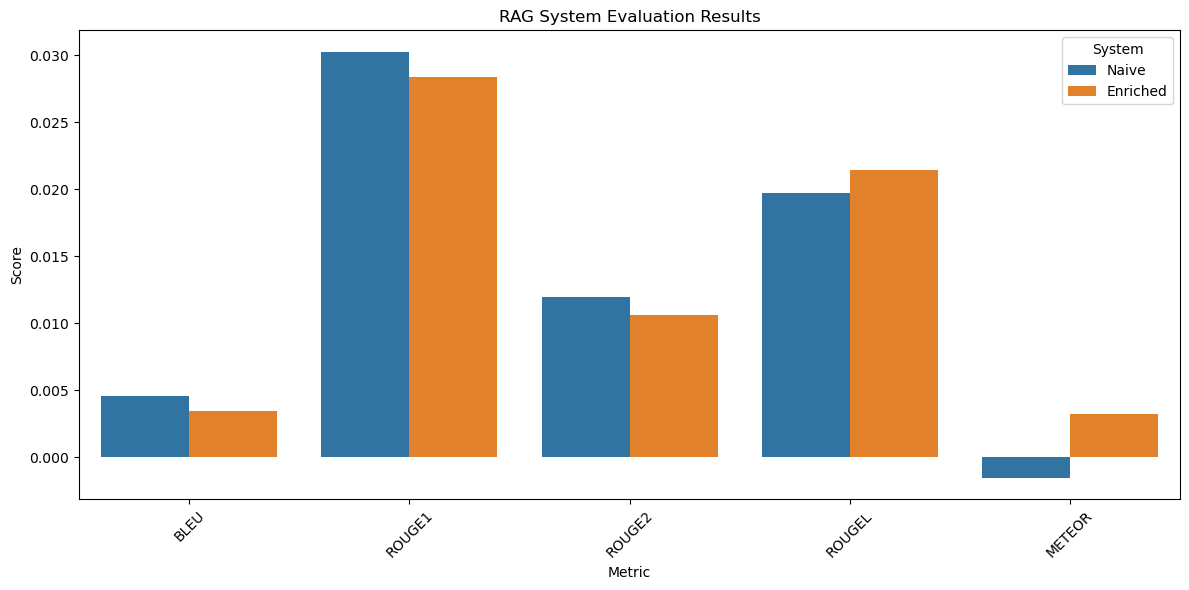

In [19]:
# Initialize evaluator and run evaluation
evaluator = RAGEvaluator(ground_truth, naive_answers, enriched_answers)
results = evaluator.evaluate_all()

# Print results
print("\nEvaluation Results:")
print("==================")
for system, metrics in results.items():
    print(f"\n{system.capitalize()} System:")
    print("-" * 20)
    for metric, score in metrics.items():
        print(f"{metric}: {score:.4f}")

# Plot results
evaluator.plot_results(results)